In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

wandb.login()

# Load the data located in /Dataset_creation/df_AD.csv
df_AD = pd.read_pickle('Dataset_creation/df_AD_timestamps.pkl')

# Reset the index
df_AD = df_AD.reset_index(drop=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lbissot (high-contrast-imaging). Use `wandb login --relogin` to force relogin


In [2]:
def reshape_dataframe(df, vec_column_name_list):
    """
    Reshape a dataframe containing vectors in order to have one row per element of the vectors.
    The metadata of the row is repeated for each element of the vectors.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to reshape
    vec_column_name_list : list
        The list of the columns containing vectors

    Returns
    -------
    df_reshaped : pandas.DataFrame
        The reshaped dataframe
    """

    columns = df.columns
    reshape_dataframe = {}

    # Initialize the dictionary
    for column in columns:
        reshape_dataframe[column] = []

    # Fill the dictionary
    for index, row in df.iterrows():
        # Create a dictionnary with only the metadata of the row, that is without the columns in vec_column_name_list
        meta_dict = row.drop(vec_column_name_list).to_dict()

        # Check whether the dimensions of the vectors are the same
        for column in vec_column_name_list:
            if len(row[column]) != len(row[vec_column_name_list[0]]):
                raise ValueError("The dimensions of the vectors are not the same")

        for i in range(len(row[vec_column_name_list[0]])):
            # Add the metadata to the dictionary
            for key, value in meta_dict.items():
                reshape_dataframe[key].append(value)

            # Add the vector to the dictionary
            for column in vec_column_name_list:
                reshape_dataframe[column].append(row[column][i])

    # Create a dataframe from the dictionary
    df_reshaped = pd.DataFrame(reshape_dataframe)
    return df_reshaped

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
# features_to_keep = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', \
#     'ESO AOS VISWFS MODE', 'ESO TEL AMBI WINDSP', 'ESO TEL AMBI RHUM', \
#         'HIERARCH ESO INS4 TEMP422 VAL', 'HIERARCH ESO TEL TH M1 TEMP', 'HIERARCH ESO TEL AMBI TEMP', \
#             'ESO DET NDIT', 'ESO DET SEQ1 DIT', 'SIMBAD_FLUX_G', 'SIMBAD_FLUX_H', 'SEEING_MEDIAN', \
#                 'SEEING_STD', 'COHERENCE_TIME_MEDIAN', 'COHERENCE_TIME_STD']

run_config = dict(
    # Model
    epochs = 1000,
    learning_rate = 0.001,
    batch_size = 32,
    n_obs_train = 5,
    loss_function = 'mse',
    optimizer = 'adam',
    architecture = 'MLP',
    hidden_size = 10,
    n_hidden_layers = 10,
    scale = 'log',
    
    # Data
    features_to_keep = ['SCFOVROT', 'SEPARATION', 'NSIGMA_CONTRAST'],
    categorical_features = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', 'ESO AOS VISWFS MODE'],
    separation_size = 124,  
)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device : {}".format(device))

Device : cpu


In [4]:
# Define the model
class MLP(nn.Sequential):
    def __init__(self, input_features, output_features, hidden_features, num_hidden_layers):
        layers = []
        layers.append(nn.Linear(input_features, hidden_features))
        layers.append(nn.ReLU())
        
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_features, hidden_features))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_features, output_features))
        
        super().__init__(*layers)

        self.initialize_weights()

    # He initialization (since we are using ReLU activations)
    def initialize_weights(self):
        for layer in self:
            if isinstance(layer, nn.Linear):
                n_in = layer.in_features
                # He initialization for ReLU activations
                std_dev = np.sqrt(2 / n_in)
                layer.weight.data.normal_(0, std_dev)
                layer.bias.data.fill_(0)

In [5]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="master-thesis", config=run_config):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the data
      print("Making the data...")
      x_train_tensor, y_train_log_tensor, x_test_tensor, y_test_log_tensor = make_data(df_AD, config)

      # make the model, data, and optimization problem
      model, criterion, optimizer = make(config)
      # print(model)

      # and use them to train the model
      print("Training the model...")
      train(model, x_train_tensor, y_train_log_tensor, criterion, optimizer, config)

    return model, x_train_tensor, y_train_log_tensor, x_test_tensor, y_test_log_tensor

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def make_data(df_AD, config):

    # Check whether df_AD contains 'SEPARATION' and 'NSIGMA_CONTRAST'
    if 'SEPARATION' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'SEPARATION'")
    if 'NSIGMA_CONTRAST' not in df_AD.columns:
        raise ValueError("df_AD must contain the column 'NSIGMA_CONTRAST'")

    # The numerical features are the ones that are not categorical
    numerical_features = list(set(config.features_to_keep) - set(config.categorical_features) - set(['SEPARATION', 'NSIGMA_CONTRAST']))

    # Get a dataframe containing only the columns we want to keep
    df_AD = df_AD[config.features_to_keep]

    # Convert the strings to numbers in order to transform it into a tensor
    # df_AD['ESO INS4 FILT3 NAME'] = pd.factorize(df_AD['ESO INS4 FILT3 NAME'])[0]
    # df_AD['ESO INS4 OPTI22 NAME'] = pd.factorize(df_AD['ESO INS4 OPTI22 NAME'])[0]
    # df_AD['ESO AOS VISWFS MODE'] = pd.factorize(df_AD['ESO AOS VISWFS MODE'])[0]

    # Get values of separation between 0 and 1
    separation = np.array(df_AD['SEPARATION'][0])
    separation = separation / np.max(separation)

    # Replace every separation vectors with the new one
    df_AD['SEPARATION'] = df_AD['SEPARATION'].apply(lambda x: np.array(x) / np.max(x))

    # Split the data into train and test sets
    train = df_AD.sample(frac=0.8, random_state=0)
    test = df_AD.drop(train.index)

    # Transform the NaN values into the median of the column of the training set (only for the numerical features)
    imp = SimpleImputer(strategy='median')
    train[numerical_features] = imp.fit_transform(train[numerical_features])
    test[numerical_features] = imp.transform(test[numerical_features])

    # Reshape the dataframes (note that the reshape is done after the train/test split to avoid data leakage)
    train = reshape_dataframe(train, ['SEPARATION', 'NSIGMA_CONTRAST'])
    test = reshape_dataframe(test, ['SEPARATION', 'NSIGMA_CONTRAST'])

    # Split the data into features and labels
    x_train = train.drop(['NSIGMA_CONTRAST'], axis=1)
    y_train = train['NSIGMA_CONTRAST']

    x_test = test.drop(['NSIGMA_CONTRAST'], axis=1)
    y_test = test['NSIGMA_CONTRAST']

    # Standardize the data
    scaler = StandardScaler()
    x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
    x_test[numerical_features] = scaler.transform(x_test[numerical_features])

    # Convert the dataframes to numpy arrays
    x_train = x_train.values
    y_train = np.array(y_train.tolist())
    x_test = x_test.values
    y_test = np.array(y_test.tolist())

    # Get the number of points to keep
    n_points = config.n_obs_train * len(separation)

    # Convert the data to tensors
    x_train_tensor = torch.tensor(x_train[:n_points], dtype=torch.float32)
    y_train_tensor = torch.tensor(np.log10(y_train[:n_points]), dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test[:n_points], dtype=torch.float32)
    y_test_tensor = torch.tensor(np.log10(y_test[:n_points]), dtype=torch.float32)

    return x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor

In [7]:
def make(config):

    # Make the model
    model = MLP(
        input_features=len(config.features_to_keep) - 1, # Don't forget to remove the target feature
        output_features=1,
        hidden_features=config.hidden_size,
        num_hidden_layers=config.n_hidden_layers
        ).to(device)

    # Define the loss function and the optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    return model, criterion, optimizer

In [8]:
def shuffle(x, y, config):

    x_shuffled = shuffle_sequences(x, config.separation_size) # Shuffle observations or batches ???
    y_shuffled = shuffle_sequences(y, config.separation_size)

    return x_shuffled, y_shuffled

def shuffle_sequences(X, seq_length):
    """
    Shuffle the order of the sequences of rows in matrix X.

    Parameters
    ----------
    X : torch.Tensor
        The matrix to shuffle
    seq_length : int
        The length of the sequences
    """

    # Check whether X is a torch.Tensor
    if not isinstance(X, torch.Tensor):
        raise TypeError("X must be a torch.Tensor")

    if not X.shape[0] % seq_length == 0:
        raise ValueError("The number of rows of X must be a multiple of seq_length")
    
    seq_indices = torch.arange(0, X.shape[0], seq_length)
    seq_indices = seq_indices[np.random.permutation(len(seq_indices))]

    X_shuffled = torch.empty_like(X)
    for i in range(len(seq_indices)):
        X_shuffled[i*seq_length:(i+1)*seq_length] = X[seq_indices[i]:seq_indices[i]+seq_length]

    return X_shuffled

def train_log(loss, epoch, batch_ctr):
    # Where the magic happens
    wandb.log({"epoch": epoch, "training loss": loss}, step=batch_ctr)

In [9]:
def train(model, x, y, criterion, optimizer, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    batch_ctr = 0

    # Run training and track with wandb
    for epoch in tqdm(range(config.epochs)):
        # Shuffle the data
        x_shuffled, y_shuffled = shuffle(x, y, config)
        
        for batch_start in range(0, len(x), config.batch_size):
            # Get a batch
            batch_end = batch_start + config.batch_size
            x_batch = x_shuffled[batch_start:batch_end]
            y_batch = y_shuffled[batch_start:batch_end]

            # Train the model
            loss = train_batch(x_batch, y_batch, model, optimizer, criterion)

            # Increment the batch counter
            batch_ctr += 1

            # Log metrics
            train_log(loss.item(), epoch, batch_ctr)


def train_batch(x, y, model, optimizer, criterion):
    x, y = x.to(device), y.to(device)
    
    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, y.view(-1, 1))
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [ ]:
def test(model, x, y, config):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        
        # Get the numpy versions of the predictions and the targets
        predictions = outputs.cpu().numpy()
        targets = y.cpu().numpy()

        mse = []
        mae = []

        # Calculate the mean squared and absolute errors for each observation
        if config.reshape:
            for i in tqdm(range(len(predictions) // separation_size)):
                start = i * separation_size
                stop = start + separation_size
                mse.append(mean_squared_error(targets[start:stop], predictions[start:stop]))
                # mae.append(mean_absolute_error(targets[start:stop], predictions[start:stop]))
        else:
            for i in tqdm(range(len(predictions))):
                # print(targets[i])
                # print(predictions[i])
                
                mse.append(mean_squared_error(targets[i], predictions[i]))
                # mae.append(mean_absolute_error(targets[i], predictions[i]))

        # Calculate the mean of the mean squared and absolute errors
        mean_mse = np.mean(mse)
        # mean_mae = np.mean(mae)
        median_mse = np.median(mse)
        # median_mae = np.median(mae)
        
        wandb.log({"mean_MSE": mean_mse, "median_MSE": median_mse})

    # Save the model in the exchangeable ONNX format
    # torch.onnx.export(model, y, "model.onnx")
    # wandb.save("model.onnx")

In [10]:
def plot_predictions(model, X, y, idx):
    separation = df_AD['SEPARATION'].iloc[idx]
    
    
    start = idx * len(separation)
    stop = start + len(separation)

    prediction = model(X).detach().numpy()
    prediction = prediction[start:stop]
    contrast = y[start:stop].detach().numpy()
    separation = X[start:stop, 1].detach().numpy()

    plt.plot(separation, contrast, color='blue', label='Actual')
    plt.plot(separation, prediction, color='red', label='Predicted')
    plt.xlabel('Separation (arcsec)')
    plt.ylabel('Contrast (5-sigma)')
    plt.legend()
    plt.show()

In [11]:
# Build, train and analyze the model with the pipeline
model, x_train_tensor, y_train_log_tensor, x_test_tensor, y_test_log_tensor = model_pipeline(run_config)

Making the data...


/var/folders/hg/lm1d81c953lc1dc85gc41jd00000gn/T/ipykernel_18395/3195809256.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AD['SEPARATION'] = df_AD['SEPARATION'].apply(lambda x: np.array(x) / np.max(x))


x_train_tensor.shape = torch.Size([620, 2])
y_train_log_tensor.shape = torch.Size([620])
MLP(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=10, bias=True)
  (9): ReLU()
  (10): Linear(in_features=10, out_features=10, bias=True)
  (11): ReLU()
  (12): Linear(in_features=10, out_features=10, bias=True)
  (13): ReLU()
  (14): Linear(in_features=10, out_features=10, bias=True)
  (15): ReLU()
  (16): Linear(in_features=10, out_features=10, bias=True)
  (17): ReLU()
  (18): Linear(in_features=10, out_features=10, bias=True)
  (19): ReLU()
  (20): Linear(in_features=10, out_features=1, bias=True)
)
Training the model...


100%|██████████| 1000/1000 [00:21<00:00, 45.53it/s]

Model trained!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training loss,▂▃▁█▂█▁▁▃▂▁▁▂▃▂▇▁▁▂▁▅▃▁▁▂▅▁▁▂▁▃▁▁▁▂▁▂▁▁▂
epoch,999
training loss,0.02282


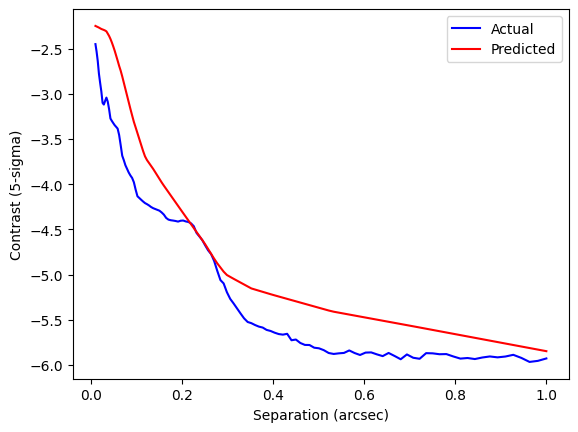

In [18]:
# Plot the predicted values vs the actual ones for one observation
plot_predictions(model, x_train_tensor, y_train_log_tensor, 4)